# Pylops - CUDA basic linear operators

### Author: M.Ravasi

In this notebook we will experiment with Pytorch to assess its usability as backend for CUDA enabled operators

In [1]:
!pip install pylops
!pip install git+https://git@github.com/equinor/pylops-gpu.git@master

  Cloning https://git@github.com/equinor/pylops-gpu.git (to revision master) to /tmp/pip-req-build-wvqmsee3
  Running command git clone -q https://git@github.com/equinor/pylops-gpu.git /tmp/pip-req-build-wvqmsee3
  Stored in directory: /tmp/pip-ephem-wheel-cache-wo4prsch/wheels/c7/f0/0b/513e9be2dad0cbe2a900c0414a94bcae8778093383364aab9a
Successfully built pylops-gpu


In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%pylab inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import torch
import scipy as sp
import matplotlib.pyplot as plt
import pylops

from scipy.sparse.linalg import cg
from pylops import Diagonal, MatrixMult
from pylops.utils import dottest
from pylops_gpu.utils.backend import device
from pylops_gpu.utils import dottest as gdottest
from pylops_gpu import Diagonal as gDiagonal

Populating the interactive namespace from numpy and matplotlib


In [3]:
dev = device()
print('PyLops-gpu working on %s...' % dev)

torch.cuda.empty_cache()

PyLops-gpu working on cuda...


## Diagonal

Example with model and data already on GPU

In [4]:
n = int(1e6)
xg = torch.ones(n, dtype=torch.float32).to(dev)
dg = (torch.arange(0, n, dtype=torch.float32) + 1.).to(dev)

x = xg.cpu().numpy()
d = dg.cpu().numpy()

Dop = Diagonal(d)
Dop_gpu = gDiagonal(dg, device=dev)
dottest(Dop, n, n, verb=True)
gdottest(Dop_gpu, n, n, device=dev, verb=True)

# y = Dx
yg = Dop_gpu * xg
print('y', yg)

Dot test passed, v^T(Opu)=-250838374.710280 - u^T(Op^Tv)=-250838374.710279
Dot test passed, v^T(Opu)=124995436544.000000 - u^T(Op^Tv)=124995436544.000000
y tensor([1.0000e+00, 2.0000e+00, 3.0000e+00,  ..., 1.0000e+06, 1.0000e+06,
        1.0000e+06], device='cuda:0')


In [5]:
%timeit -n 10 Dop * x
%timeit -n 10 Dop_gpu * xg

10 loops, best of 3: 978 µs per loop
10 loops, best of 3: 21.9 µs per loop


Example with model and data transfered from and to gpu in forward and adjoint operations

Dot test passed, v^T(Opu)=124904030208.000000 - u^T(Op^Tv)=124904030208.000000
y tensor([1.0000e+00, 2.0000e+00, 3.0000e+00,  ..., 1.0000e+06, 1.0000e+06,
        1.0000e+06], device='cuda:0')


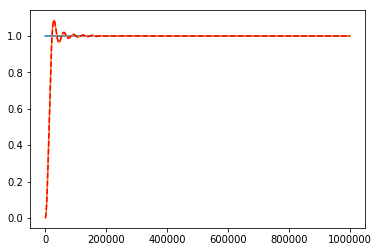

In [6]:
n = int(1e6)
xg = torch.ones(n, dtype=torch.float32).to(dev)
dg = (torch.arange(0, n, dtype=torch.float32) + 1.).to(dev)

xc = xg.cpu()
x = xg.cpu().numpy()
d = dg.cpu().numpy()

Dop = Diagonal(d)
Dop_gpu = gDiagonal(dg, device=dev, togpu=(True, True), tocpu=(True, True))
gdottest(Dop_gpu, n, n, verb=True)

# y = Dx
y = Dop_gpu * x
print('y', yg)

# xinv = D^-1 y
xinv = Dop / y
xinvg = Dop_gpu / y

plt.figure()
plt.plot(x)
plt.plot(xinv)
plt.plot(xinvg, '--r')

In [7]:
Dop_gpu = gDiagonal(dg, device=dev, togpu=(True, True))

%timeit -n 10 Dop * x
%timeit -n 10 Dop_gpu * xc

10 loops, best of 3: 730 µs per loop
10 loops, best of 3: 701 µs per loop


In [8]:
Dop_gpu = gDiagonal(dg, device=dev, togpu=(True, True), tocpu=(True, True))

%timeit -n 10 Dop * x
%timeit -n 10 Dop_gpu * xc

10 loops, best of 3: 747 µs per loop
10 loops, best of 3: 1.82 ms per loop


Note here how we get hit by the cost of moving x and y back and forth between CPU and GPU.

# 1D Convolution

In [9]:
N = 11
Nh = 3
x = np.zeros(N)
x[N//2] = 1

h = np.arange(Nh)+1
y = np.convolve(x, h, mode='same')
print(y)
print(y.shape)

[0. 0. 0. 0. 1. 2. 3. 0. 0. 0. 0.]
(11,)


In [10]:
xt = torch.zeros(N)
xt[N//2] = 1

ht = torch.torch.arange(0, Nh, dtype=torch.float) + 1.
yt = torch.torch.conv_transpose1d(xt.reshape(1, 1, N), ht.reshape(1, 1, 3), padding=Nh//2)
print(yt)
print(yt.shape)

tensor([[[0., 0., 0., 0., 1., 2., 3., 0., 0., 0., 0.]]])
torch.Size([1, 1, 11])


In [11]:
y = np.correlate(x, h, mode='same')
print(y)

yt = torch.torch.conv1d(xt.reshape(1, 1, N), ht.reshape(1, 1, 3), padding=Nh//2)
print(yt)
print(yt.shape)

[0. 0. 0. 0. 3. 2. 1. 0. 0. 0. 0.]
tensor([[[0., 0., 0., 0., 3., 2., 1., 0., 0., 0., 0.]]])
torch.Size([1, 1, 11])


In [12]:
xt = torch.zeros((1000, N))
xt[:, N//2] = 1
ht = torch.torch.arange(0, Nh, dtype=torch.float) + 1.

xc = xt.to(dev)
hc = ht.to(dev)

yt = torch.torch.conv1d(xt.reshape(1000, 1, N), ht.reshape(1, 1, 3), padding=Nh//2)
print(yt.shape)
yc = torch.torch.conv1d(xc.reshape(1000, 1, N), hc.reshape(1, 1, 3), padding=Nh//2)
print(yc.shape)

% timeit torch.torch.conv1d(xt.reshape(1000, 1, N), ht.reshape(1, 1, 3), padding=Nh//2)
% timeit torch.torch.conv1d(xc.reshape(1000, 1, N), hc.reshape(1, 1, 3), padding=Nh//2)

torch.Size([1000, 1, 11])
torch.Size([1000, 1, 11])
1000 loops, best of 3: 490 µs per loop
The slowest run took 9.99 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 3: 63.9 µs per loop


## MatrixMult

In [0]:
n = 2000
niter = 5

Dot product (vector-vector)

In [14]:
z = np.ones(n, dtype=np.float32)
zgc = torch.ones(n, dtype=torch.float32)
zg = torch.ones(n, dtype=torch.float32).to(dev)

% timeit -n 40 -r 3 z.dot(z)
% timeit -n 40 -r 3 zgc.dot(zgc)
% timeit -n 40 -r 3 zg.dot(zg)
% timeit -n 40 -r 3 zg.matmul(zg)
% timeit -n 40 -r 3 torch.sum(zg*zg)

40 loops, best of 3: 1.1 µs per loop
40 loops, best of 3: 5.48 µs per loop
40 loops, best of 3: 62.2 µs per loop
40 loops, best of 3: 58.8 µs per loop
40 loops, best of 3: 30.1 µs per loop


Dot product (matrix-vector)

In [15]:
A = np.random.randn(n, n).astype(np.float32)
Agc = torch.from_numpy(A)
Ag = torch.from_numpy(A).to(dev)
zgg = zg.reshape(n, 1)

% timeit -n 40 -r 3 A.dot(z)
% timeit -n 40 -r 3 np.matmul(A, z)
% timeit -n 40 -r 3 Agc.matmul(zgc)
% timeit -n 40 -r 3 Ag.matmul(zg)
% timeit -n 40 -r 3 Ag.mm(zgg)

40 loops, best of 3: 480 µs per loop
40 loops, best of 3: 486 µs per loop
40 loops, best of 3: 579 µs per loop
40 loops, best of 3: 15.7 µs per loop
40 loops, best of 3: 13.1 µs per loop


We can see how numpy's dot product seem to always win for vector-vector computations but in case of matrix-matrix pytorch on cuda outperforms numpy when n grows (roughly n>500)

In [0]:
def conjgrad_old(A, b, x0, niter):
    'Conjugate-gradient algorithm for minimizing |A x - dat|^2'
    x = x0
    r = b-A._matvec(x).ravel()
    d = r.copy()
    k = r.dot(r)
    k0 = k
    for iter in range(niter):
        a = r.dot(r) / d.dot(A._matvec(d).ravel())
        x = x + a*d
        rnew = r - a*A._matvec(d).ravel()
        k = rnew.dot(rnew)
        b = rnew.dot(rnew) / r.dot(r)
        d = rnew + b*d;
        r = rnew.copy()
    return x
  
def conjgrad(A, b, x, niter):
    'Conjugate-gradient algorithm for minimizing |A x - dat|^2'
    r = b - A._matvec(x)
    d = r.copy()
    k = r.dot(r)
    for iter in range(niter):
        #if iter == 0:
        #  Ad = A._matvec(r)
        #  dAd = r.dot(Ad)
        #else:
        Ad = A._matvec(d)
        dAd = d.dot(Ad)
        a = k / dAd
        x += a*d
        r -= a*Ad
        kold = k
        k = r.dot(r)
        b = k / kold
        d = r + b*d;
    return x
  
def conjgrad_gpu(A, b, x, niter):
    'Conjugate-gradient algorithm for minimizing |A x - dat|^2'
    r = b - A.matmul(x)
    d = r.clone()
    kold = torch.sum(r*r)
    for iter in range(niter):
        Ad = A.matmul(d)
        dAd = torch.sum(d*Ad)
        a = kold / dAd
        x += a*d
        r -= a*Ad
        k = torch.sum(r*r)
        b = k / kold
        d = r + b*d;
        kold = k
    return x

In [17]:
x = np.ones(n, dtype=np.float32)
A = np.random.randn(n, n).astype(np.float32)
ATA = np.dot(A.T, A)

Aop = MatrixMult(ATA)

y = Aop.matvec(x)
xinv_sp = cg(Aop, y, maxiter=niter)[0]
xinv_old = conjgrad_old(Aop, y, np.zeros_like(x), niter)
xinv = conjgrad(Aop, y, np.zeros_like(x), niter)

print(np.linalg.norm(xinv - xinv_sp))
print(np.linalg.norm(xinv - xinv_old))

2.6356795739985016e-05
0.0


8.590194e-05


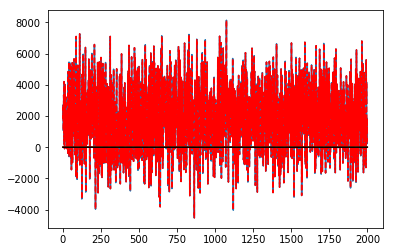

In [18]:
xg = torch.ones(n, dtype=torch.float32).to(dev)
x0g = torch.zeros(n, dtype=torch.float32).to(dev)
Ag = torch.from_numpy(A).to(dev)
ATAg = torch.matmul(Ag.t(), Ag)

yg = ATAg.matmul(xg)
plt.plot(y)
plt.plot(yg.cpu().numpy(), '--r')
plt.plot(y-yg.cpu().numpy(), 'k')

xinvg = conjgrad_gpu(ATAg, yg, torch.zeros(n, dtype=torch.float32).to(dev), niter)
print(np.linalg.norm(xinv - xinvg.cpu().numpy()))

plt.plot(x)
plt.plot(xinvg.cpu().numpy(), '--r')
plt.plot(x-xinvg.cpu().numpy(), 'k')

In [19]:
niter = 3

%timeit -n 2 cg(Aop, y, maxiter=niter)[0]
%timeit -n 2 conjgrad(Aop, y, np.zeros_like(x), niter)
%timeit -n 2 conjgrad_gpu(ATAg, yg, x0g, niter)

2 loops, best of 3: 28.7 ms per loop
2 loops, best of 3: 2.21 ms per loop
2 loops, best of 3: 920 µs per loop


In [20]:
niter = 300

%timeit -n 2 -r 2 cg(Aop, y, maxiter=niter)[0]
%timeit -n 2 -r 2 conjgrad(Aop, y, np.zeros_like(x), niter)
%timeit -n 2 -r 2 conjgrad_gpu(ATAg, yg, x0g, niter)

2 loops, best of 2: 2.27 s per loop
2 loops, best of 2: 168 ms per loop
2 loops, best of 2: 74.5 ms per loop


For large enough problems the gpu implementation of cg seem to outperform greatly scipy (mostly because the speedup in matrix-vector computation outreaches the slow down in  vector-vector).

**TO DO**: Try other GPU frameworks (cupy, scikit-cuda) and compare matrix-matrix, matrix-vector